## India ML Hiring Hackathon

### Loading Packages

In [1]:
import seaborn as sns
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import date, timedelta, datetime
from IPython.display import display
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
import time
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Custom Functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def generate_date_features(df, fldname, drop=True):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre+"_isweekend"]=df[targ_pre+"Dayofweek"].apply(lambda x:1 if x==5 or x==6 else 0)
    if drop: df.drop(fldname, axis=1, inplace=True)
        
def group_encode(target, column_name, dataframe, name):
    df = dataframe[target].groupby(dataframe[column_name]).agg({ name + '_min':'min'
                                                               ,name + '_max':'max'
                                                               ,name + '_median':'median'
                                                               ,name + '_mean':'mean'
                                                               })
    df.reset_index(inplace=True)
    dataframe = pd.merge(dataframe, df, how='left', on=column_name)
    
    return dataframe

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)


### Loading Train and Test datasets

In [4]:
Path = './data/india_ml_hackathon/'

In [5]:
date_columns = ['origination_date', 'first_payment_date']

In [6]:
train = pd.read_csv(f'{Path}train.csv', parse_dates=date_columns, infer_datetime_format=True)

In [7]:
test = pd.read_csv(f'{Path}test.csv', parse_dates=date_columns, infer_datetime_format=True)

In [8]:
submission = pd.read_csv(f'{Path}sample_submission.csv')

In [9]:
test['m13'] = np.nan
test['first_payment_date'] = pd.to_datetime(test['first_payment_date'], format='%b-%y')

In [10]:
train.shape, test.shape, submission.shape

((116058, 29), (35866, 29), (35866, 2))

In [11]:
submission.head()

,loan_id,m13
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
display_all(train.head())

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,2012-05-01,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,2012-03-01,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,2012-03-01,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,2012-04-01,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,2012-04-01,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [13]:
train['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

In [ ]:
train['m13'].value_counts(normalize=True)

0    0.99452
1    0.00548
Name: m13, dtype: float64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 29 columns):
loan_id                     116058 non-null int64
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null datetime64[ns]
first_payment_date          116058 non-null datetime64[ns]
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null float64
m1                          116058 non-null int64
m2  

In [ ]:
train.describe()

,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
count,1.160580e+05,116058.000000,1.160580e+05,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,5.494155e+11,3.868961,2.082262e+05,292.280997,67.431939,1.593186,30.742293,769.926778,2.786288,459.611565,0.003257,0.003197,0.002059,0.001973,0.002180,0.003533,0.003421,0.004162,0.004825,0.005359,0.006617,0.007109,0.008065,0.005480
std,2.597560e+11,0.461020,1.146851e+05,89.762415,17.291719,0.491242,9.730798,42.210706,8.096464,381.946926,0.056977,0.063354,0.051391,0.055427,0.062161,0.082638,0.087553,0.100961,0.113128,0.128242,0.148430,0.162884,0.178128,0.073824
min,1.000009e+11,2.250000,1.100000e+04,60.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.244656e+11,3.500000,1.200000e+05,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.486239e+11,3.875000,1.830000e+05,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,740.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.743034e+11,4.125000,2.780000e+05,360.000000,80.000000,2.000000,39.000000,800.000000,0.000000,791.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.999971e+11,6.750000,1.200000e+06,360.000000,97.000000,2.000000,64.000000,840.000000,40.000000,836.000000,1.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,1.000000


In [ ]:
numerical = train._get_numeric_data().columns.tolist()
categorical = ['source', 'financial_institution', 'loan_purpose', 'insurance_type']

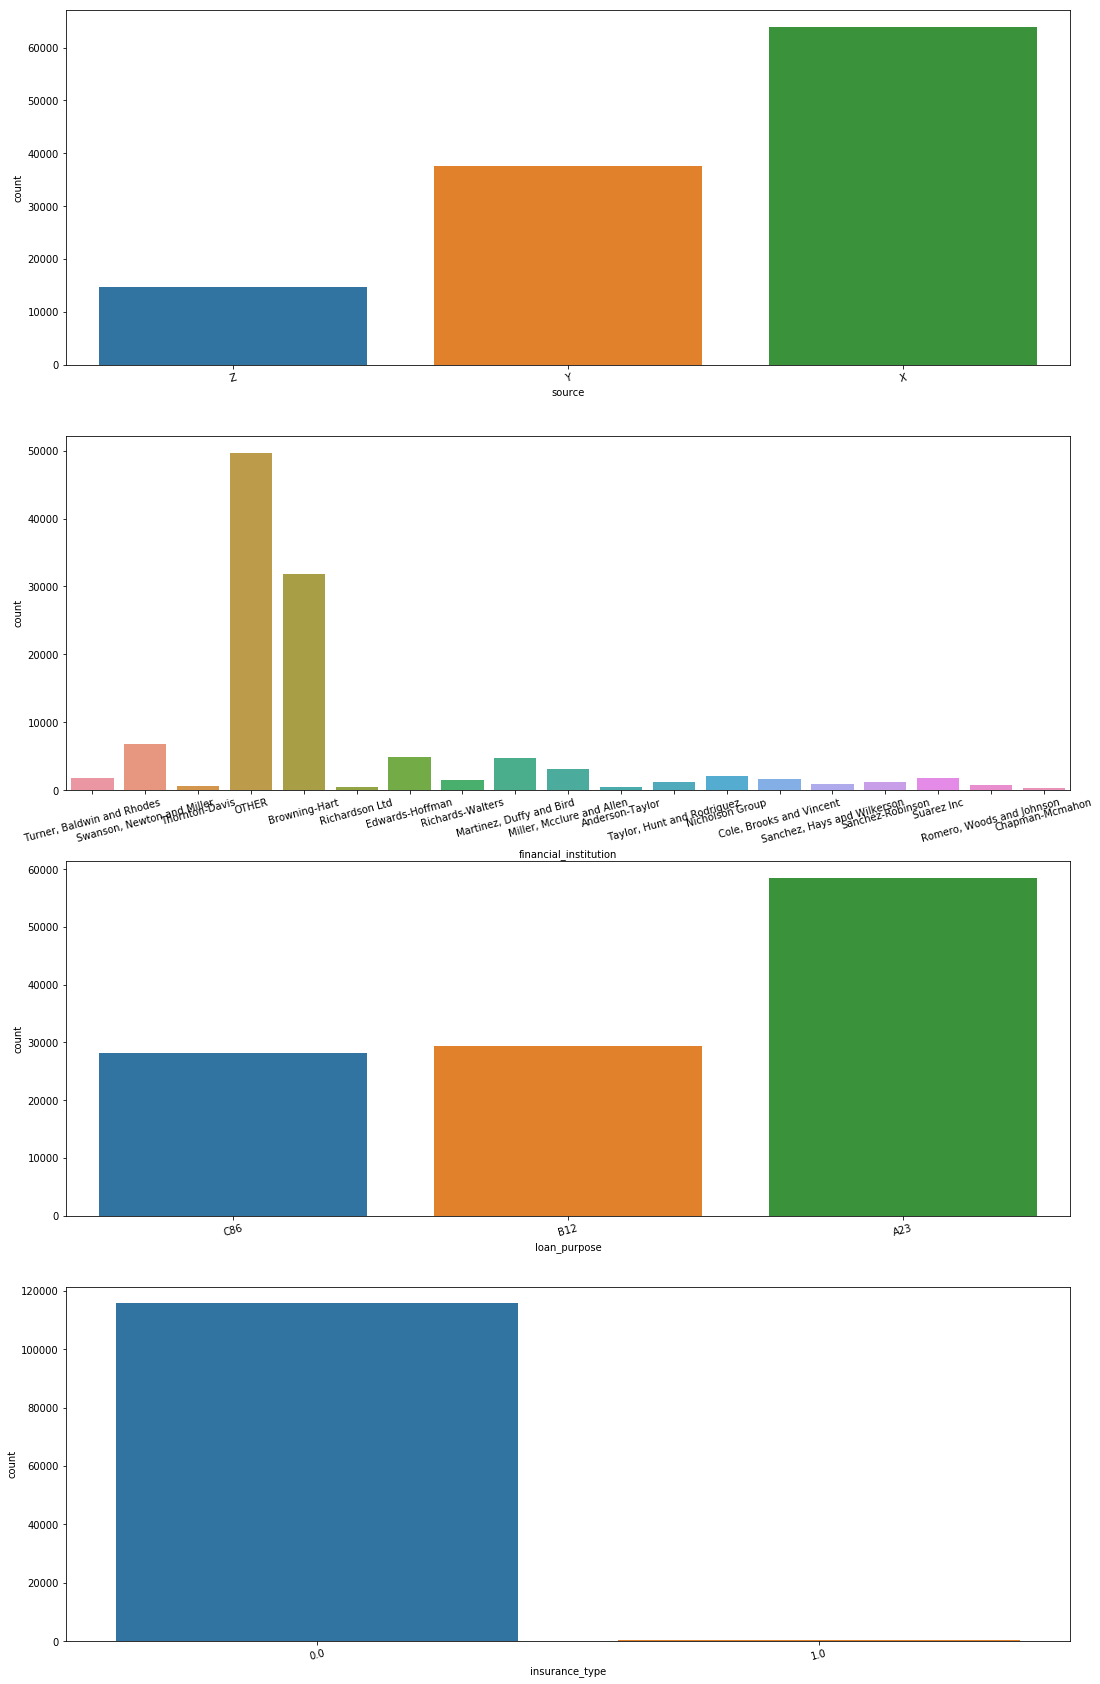

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(18, 30))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efde6807c50>,
      dtype=object)

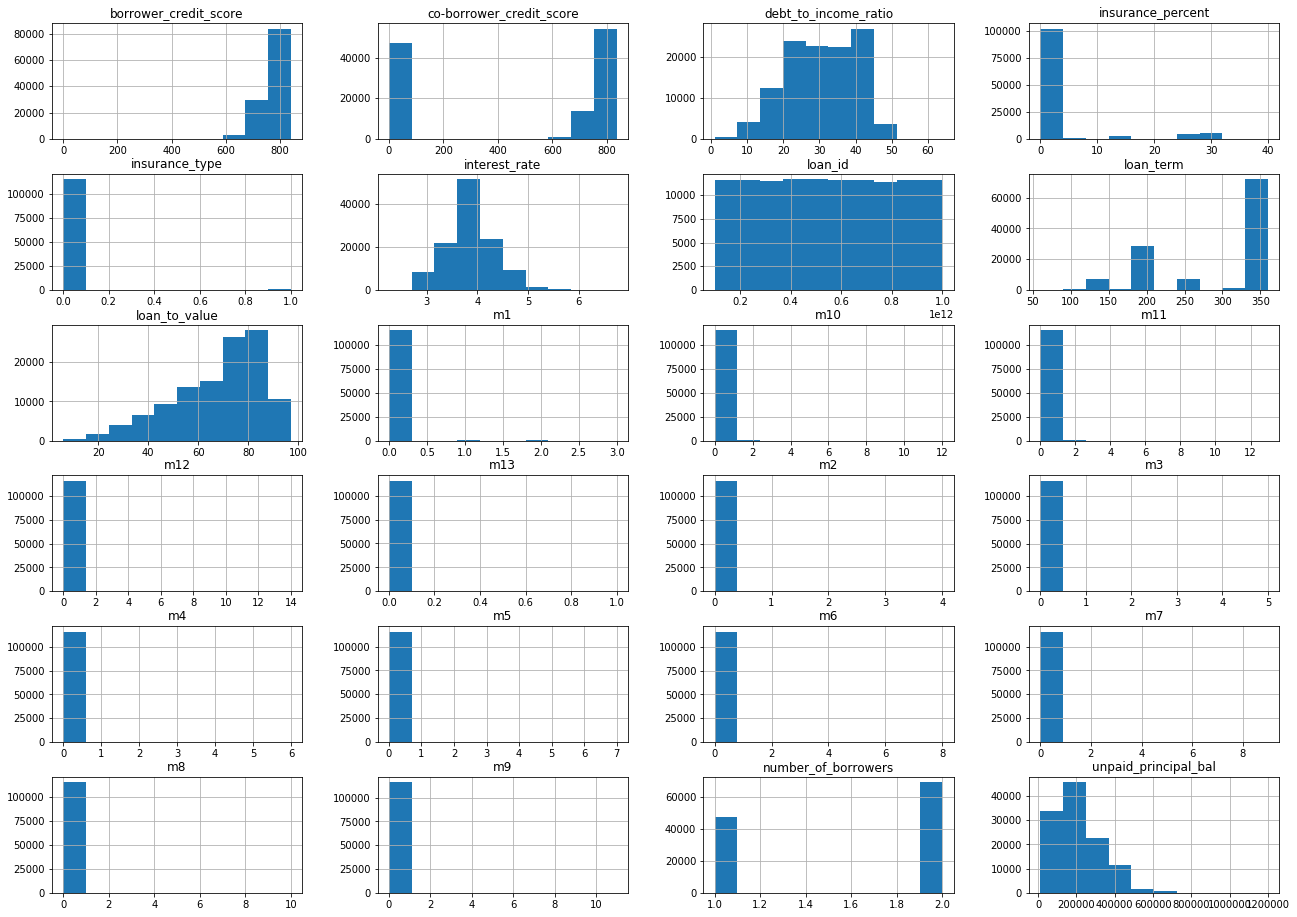

In [ ]:
train[numerical].hist(figsize=(22, 16), layout=(6, 4))

### Check for missing values

In [ ]:
for df in (train, test):
    missing_stats = df.isnull().mean()
    print(round(100 * missing_stats[missing_stats != 0],2))

Series([], dtype: float64)
m13    100.0
dtype: float64


In [ ]:
train.shape, test.shape

((116058, 29), (35866, 29))

### Feature Engineering

In [ ]:
for df in (train, test):
    
    df['days_since_origination'] = (df['first_payment_date'] - df['origination_date']).dt.days
    df['total_months'] = df['loan_term']/30
    df['final_payment_date'] = pd.to_datetime(df['first_payment_date']) + df['loan_term'].apply(lambda x: pd.Timedelta(x, unit='D'))
    df['daily_loan_value'] = df['unpaid_principal_bal']/df['loan_term']
    df['value_cost'] = df['unpaid_principal_bal']/(df['loan_to_value']/100)
    df['monthly_loan_value'] = df['unpaid_principal_bal']/df['total_months']
    df['interest_amt'] = (df['unpaid_principal_bal'] * df['interest_rate'] * df['loan_term'])/(100*365)
    df['final_amt'] = df['unpaid_principal_bal'] + df['interest_amt']
    df['income_amt'] = df['unpaid_principal_bal'] / df['debt_to_income_ratio']
    df['principal_per_borrower'] = df['unpaid_principal_bal']/df['number_of_borrowers']
    df['interest_per_borrower'] = df['interest_amt']/df['number_of_borrowers']
    df['insurance_covered_amt'] = (df['unpaid_principal_bal'] * df['insurance_percent'])/100
    df['uninsured_amt'] = df['unpaid_principal_bal'] - df['insurance_covered_amt']
    df['co_borrower_score_high'] = np.where(df['co-borrower_credit_score'] > df['borrower_credit_score'], 1, 0)
    df['co_borrower_score_NA'] = np.logical_and(df['number_of_borrowers'] > 1, df['co-borrower_credit_score'] == 0)
    df['co-borrower_credit_score'] = np.where(df['co_borrower_score_NA'] == False
                                             ,df['co-borrower_credit_score'].median()
                                             ,df['co-borrower_credit_score'])
    df['borrower_credit_score'] = np.where(df['borrower_credit_score'] < 300
                                           , df['borrower_credit_score'].median()
                                           , df['borrower_credit_score'])
    df['avg_borrower_credit_score'] = df[['borrower_credit_score'
                                          , 'co-borrower_credit_score']].sum(axis=1)/df['number_of_borrowers']
    df['Q1_deliquency_mean'] = df[['m1', 'm2', 'm3']].mean(axis=1)
    df['Q2_deliquency_mean'] = df[['m4', 'm5', 'm6']].mean(axis=1)
    df['Q3_deliquency_mean'] = df[['m7', 'm8', 'm9']].mean(axis=1)
    df['Q4_deliquency_mean'] = df[['m10', 'm11', 'm12']].mean(axis=1)
    df['H1_deliquency_mean'] = df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6']].mean(axis=1)
    df['H2_deliquency_mean'] = df[['m7', 'm8', 'm9', 'm10', 'm11', 'm12']].mean(axis=1)
    df['Y1_deliquency_mean'] = df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']].mean(axis=1)
    df['Q1_deliquency_total'] = df[['m1', 'm2', 'm3']].sum(axis=1)
    df['Q2_deliquency_total'] = df[['m4', 'm5', 'm6']].sum(axis=1)
    df['Q3_deliquency_total'] = df[['m7', 'm8', 'm9']].sum(axis=1)
    df['Q4_deliquency_total'] = df[['m10', 'm11', 'm12']].sum(axis=1)
    df['H1_deliquency_total'] = df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6']].sum(axis=1)
    df['H2_deliquency_total'] = df[['m7', 'm8', 'm9', 'm10', 'm11', 'm12']].sum(axis=1)
    df['Y1_deliquency_total'] = df[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']].sum(axis=1)
    df['avg_delinquency_credit_score'] = np.where(df['Y1_deliquency_total'] == 0
                                                  , df['borrower_credit_score']
                                                  , df['borrower_credit_score']/df['Y1_deliquency_total'])
    df['delinquency_value'] = df['monthly_loan_value'] * df['Y1_deliquency_mean']
    df['deliquency90_issue'] = np.logical_and((df['Q2_deliquency_total'] 
                                               + df['H2_deliquency_total']) > 0
                                              , df['loan_term'] <= 90)
    df['deliquency120_issue'] = np.logical_and((df[['m5', 'm6']].sum(axis=1) 
                                               + df['H2_deliquency_total']) > 0
                                              , df['loan_term'] <= 120)
    df['deliquency180_issue'] = np.logical_and(df['H2_deliquency_total'] > 0, df['loan_term'] <= 180)
    df['deliquency240_issue'] = np.logical_and((df['m9'] + df['Q4_deliquency_total']) > 0, df['loan_term'] <= 240)
    df['deliquency300_issue'] = np.logical_and((df['m11'] + df['m12']) > 0, df['loan_term'] <= 300)

    

In [ ]:
group_cols = ['source', 'financial_institution', 'loan_purpose']
for col in group_cols:
    ## train
    train = group_encode('borrower_credit_score', col, train, col + '_bcs')
    train = group_encode('co-borrower_credit_score', col, train, col + '_cbcs')
    train = group_encode('debt_to_income_ratio', col, train, col + '_dtir')
    train = group_encode('interest_rate', col, train, col + '_ir')
    train = group_encode('loan_to_value', col, train, col + '_ltv')  
    train = group_encode('unpaid_principal_bal', col, train, col + '_upb')  
    train = group_encode('loan_term', col, train, col + '_lt')  
    train = group_encode('m1', col, train, col + '_m1')  
    train = group_encode('m2', col, train, col + '_m2')  
    train = group_encode('m3', col, train, col + '_m3')  
    train = group_encode('m4', col, train, col + '_m4')  
    train = group_encode('m5', col, train, col + '_m5')  
    train = group_encode('m6', col, train, col + '_m6')  
    train = group_encode('m7', col, train, col + '_m7')  
    train = group_encode('m8', col, train, col + '_m8')  
    train = group_encode('m9', col, train, col + '_m9')  
    train = group_encode('m10', col, train, col + '_m10')  
    train = group_encode('m11', col, train, col + '_m11')  
    train = group_encode('m12', col, train, col + '_m12')

    ## test
    test = group_encode('borrower_credit_score', col, test, col + '_bcs')
    test = group_encode('co-borrower_credit_score', col, test, col + '_cbcs')
    test = group_encode('debt_to_income_ratio', col, test, col + '_dtir')
    test = group_encode('interest_rate', col, test, col + '_ir')
    test = group_encode('loan_to_value', col, test, col + '_ltv')  
    test = group_encode('unpaid_principal_bal', col, test, col + '_upb')  
    test = group_encode('loan_term', col, test, col + '_lt')  
    test = group_encode('m1', col, test, col + '_m1')  
    test = group_encode('m2', col, test, col + '_m2')  
    test = group_encode('m3', col, test, col + '_m3')  
    test = group_encode('m4', col, test, col + '_m4')  
    test = group_encode('m5', col, test, col + '_m5')  
    test = group_encode('m6', col, test, col + '_m6')  
    test = group_encode('m7', col, test, col + '_m7')  
    test = group_encode('m8', col, test, col + '_m8')  
    test = group_encode('m9', col, test, col + '_m9')  
    test = group_encode('m10', col, test, col + '_m10')  
    test = group_encode('m11', col, test, col + '_m11')  
    test = group_encode('m12', col, test, col + '_m12')

In [ ]:
date_columns = ['origination_date', 'first_payment_date', 'final_payment_date']
for col in date_columns:
    generate_date_features(train, col, drop=True)
    generate_date_features(test, col, drop=True)

In [ ]:
train_cats(train)
apply_cats(test, train)

In [ ]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
            df[name] = col.cat.codes+1

for n,c in train.items(): numericalize(train, c, n, max_n_cat=None)
for n,c in test.items(): numericalize(test, c, n, max_n_cat=None)

In [ ]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,days_since_origination,total_months,daily_loan_value,value_cost,monthly_loan_value,interest_amt,final_amt,income_amt,principal_per_borrower,interest_per_borrower,insurance_covered_amt,uninsured_amt,co_borrower_score_high,co_borrower_score_NA,avg_borrower_credit_score,Q1_deliquency_mean,Q2_deliquency_mean,Q3_deliquency_mean,Q4_deliquency_mean,H1_deliquency_mean,H2_deliquency_mean,Y1_deliquency_mean,Q1_deliquency_total,Q2_deliquency_total,Q3_deliquency_total,Q4_deliquency_total,H1_deliquency_total,H2_deliquency_total,Y1_deliquency_total,avg_delinquency_credit_score,delinquency_value,deliquency90_issue,deliquency120_issue,deliquency180_issue,deliquency240_issue,deliquency300_issue,source_bcs_min,source_bcs_max,source_bcs_median,source_bcs_mean,source_cbcs_min,source_cbcs_max,source_cbcs_median,source_cbcs_mean,source_dtir_min,source_dtir_max,source_dtir_median,source_dtir_mean,source_ir_min,source_ir_max,source_ir_median,source_ir_mean,source_ltv_min,source_ltv_max,source_ltv_median,source_ltv_mean,source_upb_min,source_upb_max,source_upb_median,source_upb_mean,source_lt_min,source_lt_max,source_lt_median,source_lt_mean,source_m1_min,source_m1_max,source_m1_median,source_m1_mean,source_m2_min,source_m2_max,source_m2_median,source_m2_mean,source_m3_min,source_m3_max,source_m3_median,source_m3_mean,source_m4_min,source_m4_max,source_m4_median,source_m4_mean,source_m5_min,source_m5_max,source_m5_median,source_m5_mean,source_m6_min,source_m6_max,source_m6_median,source_m6_mean,source_m7_min,source_m7_max,source_m7_median,source_m7_mean,source_m8_min,source_m8_max,source_m8_median,source_m8_mean,source_m9_min,source_m9_max,source_m9_median,source_m9_mean,source_m10_min,source_m10_max,source_m10_median,source_m10_mean,source_m11_min,source_m11_max,source_m11_median,source_m11_mean,source_m12_min,source_m12_max,source_m12_median,source_m12_mean,financial_institution_bcs_min,financial_institution_bcs_max,financial_institution_bcs_median,financial_institution_bcs_mean,financial_institution_cbcs_min,financial_institution_cbcs_max,financial_institution_cbcs_median,financial_institution_cbcs_mean,financial_institution_dtir_min,financial_institution_dtir_max,financial_institution_dtir_median,financial_institution_dtir_mean,financial_institution_ir_min,financial_institution_ir_max,financial_institution_ir_median,financial_institution_ir_mean,financial_institution_ltv_min,financial_institution_ltv_max,financial_institution_ltv_median,financial_institution_ltv_mean,financial_institution_upb_min,financial_institution_upb_max,financial_institution_upb_median,financial_institution_upb_mean,financial_institution_lt_min,financial_institution_lt_max,financial_institution_lt_median,financial_institution_lt_mean,financial_institution_m1_min,financial_institution_m1_max,financial_institution_m1_median,financial_institution_m1_mean,financial_institution_m2_min,financial_institution_m2_max,financial_institution_m2_median,financial_institution_m2_mean,financial_institution_m3_min,financial_institution_m3_max,financial_institution_m3_median,financial_institution_m3_mean,financial_institution_m4_min,financial_institution_m4_max,financial_institution_m4_median,financial_institution_m4_mean,financial_institution_m5_min,financial_institution_m5_max,financial_institution_m5_median,financial_institution_m5_mean,financial_institution_m6_min,financial_institution_m6_max,financial_institution_m6_median,financial_institution_m6_mean,financial_institution_m7_min,financial_institution_m7_max,financial_institution_m7_median,financial_institution_m7_mean,financial_institution_m8_min,financial_institution_m8_max,financial_institution_m8_median,financial_institution_m8_mean,financial_institution_m9_min,fi

In [ ]:
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,days_since_origination,total_months,daily_loan_value,value_cost,monthly_loan_value,interest_amt,final_amt,income_amt,principal_per_borrower,interest_per_borrower,insurance_covered_amt,uninsured_amt,co_borrower_score_high,co_borrower_score_NA,avg_borrower_credit_score,Q1_deliquency_mean,Q2_deliquency_mean,Q3_deliquency_mean,Q4_deliquency_mean,H1_deliquency_mean,H2_deliquency_mean,Y1_deliquency_mean,Q1_deliquency_total,Q2_deliquency_total,Q3_deliquency_total,Q4_deliquency_total,H1_deliquency_total,H2_deliquency_total,Y1_deliquency_total,avg_delinquency_credit_score,delinquency_value,deliquency90_issue,deliquency120_issue,deliquency180_issue,deliquency240_issue,deliquency300_issue,source_bcs_min,source_bcs_max,source_bcs_median,source_bcs_mean,source_cbcs_min,source_cbcs_max,source_cbcs_median,source_cbcs_mean,source_dtir_min,source_dtir_max,source_dtir_median,source_dtir_mean,source_ir_min,source_ir_max,source_ir_median,source_ir_mean,source_ltv_min,source_ltv_max,source_ltv_median,source_ltv_mean,source_upb_min,source_upb_max,source_upb_median,source_upb_mean,source_lt_min,source_lt_max,source_lt_median,source_lt_mean,source_m1_min,source_m1_max,source_m1_median,source_m1_mean,source_m2_min,source_m2_max,source_m2_median,source_m2_mean,source_m3_min,source_m3_max,source_m3_median,source_m3_mean,source_m4_min,source_m4_max,source_m4_median,source_m4_mean,source_m5_min,source_m5_max,source_m5_median,source_m5_mean,source_m6_min,source_m6_max,source_m6_median,source_m6_mean,source_m7_min,source_m7_max,source_m7_median,source_m7_mean,source_m8_min,source_m8_max,source_m8_median,source_m8_mean,source_m9_min,source_m9_max,source_m9_median,source_m9_mean,source_m10_min,source_m10_max,source_m10_median,source_m10_mean,source_m11_min,source_m11_max,source_m11_median,source_m11_mean,source_m12_min,source_m12_max,source_m12_median,source_m12_mean,financial_institution_bcs_min,financial_institution_bcs_max,financial_institution_bcs_median,financial_institution_bcs_mean,financial_institution_cbcs_min,financial_institution_cbcs_max,financial_institution_cbcs_median,financial_institution_cbcs_mean,financial_institution_dtir_min,financial_institution_dtir_max,financial_institution_dtir_median,financial_institution_dtir_mean,financial_institution_ir_min,financial_institution_ir_max,financial_institution_ir_median,financial_institution_ir_mean,financial_institution_ltv_min,financial_institution_ltv_max,financial_institution_ltv_median,financial_institution_ltv_mean,financial_institution_upb_min,financial_institution_upb_max,financial_institution_upb_median,financial_institution_upb_mean,financial_institution_lt_min,financial_institution_lt_max,financial_institution_lt_median,financial_institution_lt_mean,financial_institution_m1_min,financial_institution_m1_max,financial_institution_m1_median,financial_institution_m1_mean,financial_institution_m2_min,financial_institution_m2_max,financial_institution_m2_median,financial_institution_m2_mean,financial_institution_m3_min,financial_institution_m3_max,financial_institution_m3_median,financial_institution_m3_mean,financial_institution_m4_min,financial_institution_m4_max,financial_institution_m4_median,financial_institution_m4_mean,financial_institution_m5_min,financial_institution_m5_max,financial_institution_m5_median,financial_institution_m5_mean,financial_institution_m6_min,financial_institution_m6_max,financial_institution_m6_median,financial_institution_m6_mean,financial_institution_m7_min,financial_institution_m7_max,financial_institution_m7_median,financial_institution_m7_mean,financial_institution_m8_min,financial_institution_m8_max,financial_institution_m8_median,financial_institution_m8_mean,financial_institution_m9_min,fi

In [ ]:
df = train.drop(['loan_id', 'm13'], axis=1)
y = train['m13'].values

In [ ]:
df_test = test.drop(['loan_id', 'm13'], axis=1)

In [ ]:
df.shape

(116058, 328)

## Catboost Model

In [ ]:
def cb_training(df = df, y = y, random_seed = 0):

    cb_f1_score = []
    cb_accuracy = []
    cb_recall = []
    cb_precision = []

    preds_cb = []

    cbfold=StratifiedKFold(n_splits=10, random_state=random_seed, shuffle=True)
    i = 1
    print(f"Seed: {random_seed}")
    for train_idx, val_idx in cbfold.split(df, y):
        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # training the model on oversampled 5 folds of training set
        cb = CatBoostClassifier(n_estimators=1000,
                                 verbose = False,
                                 eval_metric='F1',
                                 depth = 6,
                                 learning_rate = 0.01,
                                 od_type = "Iter",
                                 od_wait = 100,
                                 use_best_model=True,
                                 rsm=0.8,
                                 class_weights=[0.15, 0.85],
                                 random_state=random_seed
                                )

        cb.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        # testing on 1 fold of validation set
        validation_preds = cb.predict(X_val)

        fea_imp = pd.DataFrame({'col': X_train.columns, 'imp': cb.feature_importances_})
        fea_imp = fea_imp.sort_values('imp', ascending=False)
#         print(fea_imp.head(10))


        test_preds = cb.predict(df_test)
        preds_cb.append(test_preds)

        f1 = round(f1_score(y_val, validation_preds), 5)
        accuracy = accuracy_score(y_val, validation_preds)
        recall = recall_score(y_val, validation_preds)
        precision = precision_score(y_val, validation_preds)

        print(f"\nFold {i}, F1 Score: {f1}")
        cb_recall.append(recall)
        cb_accuracy.append(accuracy)
        cb_precision.append(precision)
        cb_f1_score.append(f1)

        i = i+1

    print('\nCross validated accuracy: {}'.format(np.mean(cb_accuracy)))
    print('Cross validated recall score: {}'.format(np.mean(cb_recall)))
    print('Cross validated precision score: {}'.format(np.mean(cb_precision)))
    print('Cross validated f1_score: {}'.format(np.mean(cb_f1_score)))
    print(f"Individual F1 Scores: {cb_f1_score}")
    
    return(preds_cb)


In [ ]:
cb_model_preds = cb_training(df = df, y = y, random_seed = 12345)
cb_model_preds

Seed: 12345

Fold 1, F1 Score: 0.54676

Fold 2, F1 Score: 0.55882

Fold 3, F1 Score: 0.58394

Fold 4, F1 Score: 0.53435

Fold 5, F1 Score: 0.41135

Fold 6, F1 Score: 0.44

Fold 7, F1 Score: 0.57851

Fold 8, F1 Score: 0.58333


In [ ]:
submission['m13'] = stats.mode(cb_model_preds, 0)[0][0]
submission['m13'] = submission['m13'].astype('int')
print(submission['m13'].sum()) #131
submission.head()

In [ ]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
model_name='CatBoost'
submission.to_csv(f'{Path}{model_name}_Submission_{file_timestamp}.csv', index=False)